In [22]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 

%matplotlib inline

In [23]:
from sklearn.datasets import load_boston
boston_dataset = load_boston() #import boston housing data

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [35]:
#Creating the dataframe for this dataset
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [25]:
boston['MEDV'] = boston_dataset.target #set MEDV as target

In [26]:
boston.isnull().sum() #check if there is missing data

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

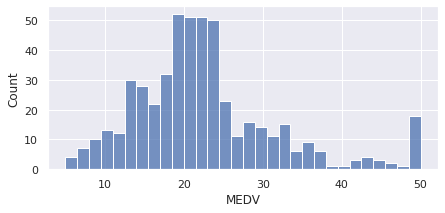

In [27]:
#plot histogram of MEDV values
sns.set(rc={'figure.figsize':(7,3)})
sns.histplot(boston['MEDV'], bins=30)
plt.show()

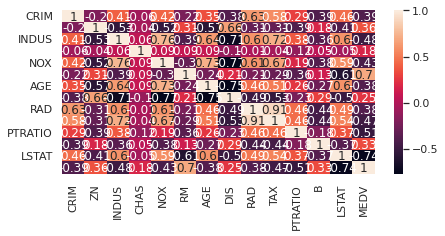

In [28]:
#Plot correlation matrix
correlation_matrix = boston.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [29]:
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import train_test_split

#Set dataframe for the fit 
X =boston
z = boston['MEDV']


scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)

Z_test_predict = []
Z_train_predict = []
mean_bias = []
mean_variance = []
bias_variance = []
testing_error=[]
training_error =[]
testing_r2=[]
training_r2 =[]

#polynomial order
poly = 3

#Value of lambda
LAMBDA = [100000,10000,1000, 100,10, 1, 0.1, 0.01, 0.001, 0.0001]

nlambdas = len(LAMBDA)

for j in range (nlambdas): #loop for lambda
    
    mse_test=[]
    r2_test=[]
    mse_train=[]
    r2_train=[]
    bias = []
    variance = []
    lmb = LAMBDA[j]
    
    #Make folds using SKlearn
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    kf.get_n_splits(X_scaled)
    
    i = 0
    for train_index, test_index in kf.split(X_scaled):
        # #Make train and test data using the folds made by SKlearn
        X_train_scaled, X_test_scaled = X_scaled[train_index], X_scaled[test_index]
        z_train, z_test = z.ravel()[train_index], z.ravel()[test_index]
        
        # Fit training data usink SKlearn
        polyreg=make_pipeline(PolynomialFeatures(poly),Ridge(lmb))
        polyreg.fit(X_train_scaled,z_train)

        # model evaluation for training set
        z_train_predict=polyreg.predict(X_train_scaled)
        Z_train_predict.append(z_train_predict)
        mse_train = (np.sqrt(mean_squared_error(z_train, z_train_predict)))
        r2_train = r2_score(z_train, z_train_predict)
        
        # model evaluation for testing set
        z_test_predict=polyreg.predict(X_test_scaled)
        Z_train_predict.append(z_test_predict)
        mse_test = (np.sqrt(mean_squared_error(z_test, z_test_predict)))
        r2_test = r2_score(z_test, z_test_predict)
        
        
        variance.append(np.var(z_test_predict , axis=0, keepdims=True))
        
        b= np.mean((z_test - np.mean(z_test_predict, axis=0, keepdims=True))**2)
        bias.append(b)  
        
        # Increment counter i
        i = i + 1
        

    print('Lamdda:', lmb)
    print("\n")
    print("The model performance for training set")
    print("--------------------------------------")
    training_error.append(np.mean(mse_train))
    print('RMSE is {}'.format(np.mean(mse_train)))
    training_r2.append(np.mean(r2_train))
    print('R2 score is {}'.format(np.mean(r2_train)))
    print("\n")

    print("The model performance for testing set")
    print("--------------------------------------")
    testing_error.append(np.mean(mse_test))
    print('RMSE is {}'.format(np.mean(mse_test)))
    testing_r2.append(np.mean(r2_test))
    print('R2 score is {}'.format(np.mean(r2_test)))
    print("\n")

    zpred = polyreg.predict(X) #dim = 1

    mean_bias.append(np.mean(bias))
    
    mean_variance.append(np.mean (variance))
    
    bias_variance.append(mean_variance[j-1]+mean_bias[j-1])
  

Lamdda: 100000


The model performance for training set
--------------------------------------
RMSE is 5.640708048557753
R2 score is 0.6317358821947204


The model performance for testing set
--------------------------------------
RMSE is 5.075637086686237
R2 score is 0.6118292448367726




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 10000


The model performance for training set
--------------------------------------
RMSE is 3.2094723002661794
R2 score is 0.8807771705851304


The model performance for testing set
--------------------------------------
RMSE is 3.2694781448661168
R2 score is 0.8389359684206966




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 1000


The model performance for training set
--------------------------------------
RMSE is 1.77801943328605
R2 score is 0.9634097676307294


The model performance for testing set
--------------------------------------
RMSE is 2.253208188170013
R2 score is 0.9235030129724632




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 100


The model performance for training set
--------------------------------------
RMSE is 0.9085384287073193
R2 score is 0.9904461424017759


The model performance for testing set
--------------------------------------
RMSE is 1.4216830493403387
R2 score is 0.9695457955362414




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 10


The model performance for training set
--------------------------------------
RMSE is 0.3587263630300042
R2 score is 0.99851057462137


The model performance for testing set
--------------------------------------
RMSE is 0.8903340032938667
R2 score is 0.9880560601218443




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 1


The model performance for training set
--------------------------------------
RMSE is 0.12113789162233282
R2 score is 0.9998301552285606


The model performance for testing set
--------------------------------------
RMSE is 0.5717627754431615
R2 score is 0.9950742377858117




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 0.1


The model performance for training set
--------------------------------------
RMSE is 0.03338563033645395
R2 score is 0.9999870993580616


The model performance for testing set
--------------------------------------
RMSE is 0.5636414917732345
R2 score is 0.9952131744574917




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 0.01


The model performance for training set
--------------------------------------
RMSE is 0.008110409113920301
R2 score is 0.9999992386616885


The model performance for testing set
--------------------------------------
RMSE is 0.5606022129040474
R2 score is 0.995264658507492




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 0.001


The model performance for training set
--------------------------------------
RMSE is 0.001725591211989436
R2 score is 0.9999999655358159


The model performance for testing set
--------------------------------------
RMSE is 0.5465017966383999
R2 score is 0.9954998719000543




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


Lamdda: 0.0001


The model performance for training set
--------------------------------------
RMSE is 0.0003346308133258735
R2 score is 0.9999999987039433


The model performance for testing set
--------------------------------------
RMSE is 0.5277340019148876
R2 score is 0.9958036486658692




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


[5.640708048557753, 3.2094723002661794, 1.77801943328605, 0.9085384287073193, 0.3587263630300042, 0.12113789162233282, 0.03338563033645395, 0.008110409113920301, 0.001725591211989436, 0.0003346308133258735]
[5.075637086686237, 3.2694781448661168, 2.253208188170013, 1.4216830493403387, 0.8903340032938667, 0.5717627754431615, 0.5636414917732345, 0.5606022129040474, 0.5465017966383999, 0.5277340019148876]


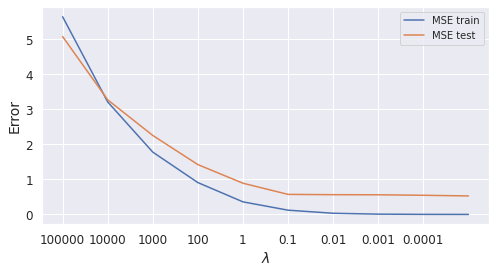

In [30]:
#plot parameters to estimate quality of the fit
plt.figure(figsize=(8,4))
plt.plot(training_error, label="MSE train")
print(training_error)
plt.plot(testing_error, label="MSE test")
print(testing_error)
plt.legend(fontsize = 10)
plt.xticks([0,1,2,3,4,5,6,7,8],["100000","10000","1000","100","1","0.1","0.01","0.001","0.0001"], fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel("Error", fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

[0.6317358821947204, 0.8807771705851304, 0.9634097676307294, 0.9904461424017759, 0.99851057462137, 0.9998301552285606, 0.9999870993580616, 0.9999992386616885, 0.9999999655358159, 0.9999999987039433]
[0.6118292448367726, 0.8389359684206966, 0.9235030129724632, 0.9695457955362414, 0.9880560601218443, 0.9950742377858117, 0.9952131744574917, 0.995264658507492, 0.9954998719000543, 0.9958036486658692]


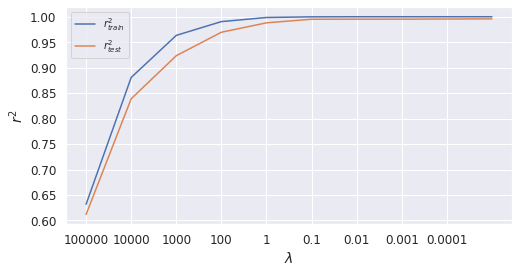

In [31]:

plt.figure(figsize=(8,4))
plt.plot(training_r2, label=r'$r^2_{train}$')
print(training_r2)
plt.plot(testing_r2, label=r'$r^2_{test}$')
print(testing_r2)
plt.legend(fontsize = 10)
plt.xticks([0,1,2,3,4,5,6,7,8],["100000","10000","1000","100","1","0.1","0.01","0.001","0.0001"], fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel(r'$r^2$', fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

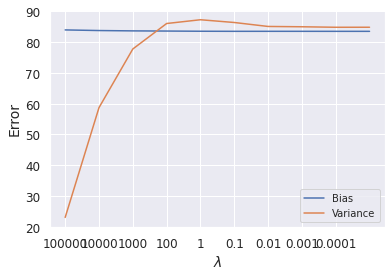

In [32]:
plt.figure(figsize=(6,4))
plt.plot(mean_bias, label="Bias")
plt.plot(mean_variance, label="Variance")
plt.legend(fontsize = 10)
plt.xticks([0,1,2,3,4,5,6,7,8],["100000","10000","1000","100","1","0.1","0.01","0.001","0.0001"], fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel("Error", fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

[107.02514883043784, 107.02514883043784, 142.46396879681265, 161.39399661784688, 169.61182400305938, 170.7753449075334, 169.85449514811643, 168.57367017925833, 168.4693774533085, 168.3003066508926]
[5.075637086686237, 3.2694781448661168, 2.253208188170013, 1.4216830493403387, 0.8903340032938667, 0.5717627754431615, 0.5636414917732345, 0.5606022129040474, 0.5465017966383999, 0.5277340019148876]


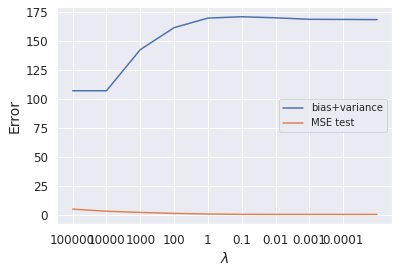

In [33]:
plt.figure(figsize=(6,4))
plt.plot(bias_variance, label="bias+variance")
print(bias_variance)
plt.plot(testing_error, label="MSE test")
print(testing_error)
plt.legend(fontsize = 10)
plt.xticks([0,1,2,3,4,5,6,7,8],["100000","10000","1000","100","1","0.1","0.01","0.001","0.0001"], fontsize=12)
plt.xlabel('$\lambda$', fontsize=14)
plt.ylabel("Error", fontsize = 14)
plt.yticks(fontsize=12)
plt.show()

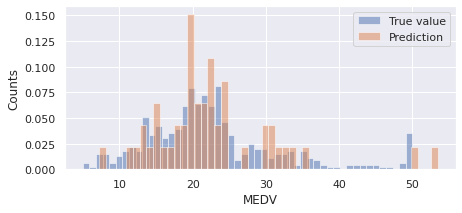

In [34]:
#plot histogram for the result and the data
from matplotlib import pyplot
pyplot.hist(boston['MEDV'], 50, density=True, alpha=0.5, label='True value')
pyplot.hist(z_test_predict, 50, density=True, alpha=0.5, label='Prediction')
plt.xlabel('MEDV')
plt.ylabel('Counts')
plt.grid(True)
pyplot.legend(loc='upper right')
plt.show()